In [1]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path
from scipy.stats import multivariate_normal
import ipywidgets as widgets
from IPython.display import display
import pandas as pd


In [2]:
def loadFile(filename):
    '''
    Reads in data file
    '''
    
    if 'Barcodes' in filename:
        col_name = ['Subject', 'Barcode']
    elif 'Landmark_Groundtruth' in filename:
        col_name = ['Subject', 'x', 'y', 'x_std', 'y_std']
    elif 'Groundtruth' in filename:
        col_name = ['Time', 'x', 'y', 'orientation']
    elif 'Measurement' in filename:
        col_name = ['Time', 'Subject', 'Range', 'Bearing']
    else:
        col_name = ['Time', 'Forward Velocity', 'Angular Velocity']
        
    data = pd.read_csv(filename, names = col_name, comment="#", delimiter = "\t", skipinitialspace = True)
    
    return data

In [3]:
loadFile("./MRCLAM_Dataset1/Landmark_Groundtruth.dat")

,Subject,x,y,x_std,y_std
0,6,5.709283,4.964045,0.000275,0.000415
1,7,5.252926,5.536569,0.000119,0.000354
2,8,3.699877,4.466423,0.000115,0.000212
3,9,2.314463,3.374987,0.000118,0.000121
4,10,0.481799,4.395972,0.000107,0.000185
5,11,3.150720,2.382949,0.000126,0.000138
6,12,4.063288,0.944294,0.000061,0.000134
7,13,2.680344,0.268352,0.000099,0.000095
8,14,0.948285,0.756013,0.000169,0.000151
9,15,3.762902,-2.030915,0.000115,0.000175


In [4]:
'''
How to deal with non time sync odometry and measurements
- email to clark?
- could potentially assume it's insignificant

Big consideration
- Won't get a full measurement vector every time we correct!
- correct this line instead of correct the whole thing

### Answers to design questions

What do we want in our state vector:
- x, y, yaw
- use all 5 robots initially, see if run time blows up

For measurements
- x and y of all five robots (doesn't seem to be a way to correct yaw)
- ask about predicting yaw

Time stamps across five robots might not be synced!

'''

"\nHow to deal with non time sync odometry and measurements\n- email to clark?\n- could potentially assume it's insignificant\n\nBig consideration\n- Won't get a full measurement vector every time we correct!\n- correct this line instead of correct the whole thing\n\n### Answers to design questions\n\nWhat do we want in our state vector:\n- x, y, yaw\n- use all 5 robots initially, see if run time blows up\n\nFor measurements\n- x and y of all five robots (doesn't seem to be a way to correct yaw)\n- ask about predicting yaw\n\nTime stamps across five robots might not be synced!\n\n"

In [5]:
robot1_gt = loadFile("./MRCLAM_Dataset1/Robot1_Groundtruth.dat")
robot2_gt = loadFile("./MRCLAM_Dataset1/Robot2_Groundtruth.dat")
robot3_gt = loadFile("./MRCLAM_Dataset1/Robot3_Groundtruth.dat")
robot4_gt = loadFile("./MRCLAM_Dataset1/Robot4_Groundtruth.dat")
robot5_gt = loadFile("./MRCLAM_Dataset1/Robot5_Groundtruth.dat")

robot1_odo = loadFile("./MRCLAM_Dataset1/Robot1_Odometry.dat")
robot2_odo = loadFile("./MRCLAM_Dataset1/Robot2_Odometry.dat")

In [6]:
robot1_gt_x = robot1_gt['x'].to_numpy()
robot2_gt_x = robot2_gt['x'].to_numpy()
robot3_gt_x = robot3_gt['x'].to_numpy()
robot4_gt_x = robot4_gt['x'].to_numpy()
robot5_gt_x = robot5_gt['x'].to_numpy()

robot1_gt_y = robot1_gt['y'].to_numpy()
robot2_gt_y = robot2_gt['y'].to_numpy()
robot3_gt_y = robot3_gt['y'].to_numpy()
robot4_gt_y = robot4_gt['y'].to_numpy()
robot5_gt_y = robot5_gt['y'].to_numpy()

robot1_gt_time = robot1_gt['Time'].to_numpy()


In [7]:
robot1_odo_time = robot1_odo['Time'].to_numpy()
robot2_odo_time = robot2_odo['Time'].to_numpy()

In [8]:
np.mean(robot1_odo_time[1:] - robot1_odo_time[:-1])

0.015226205190834653

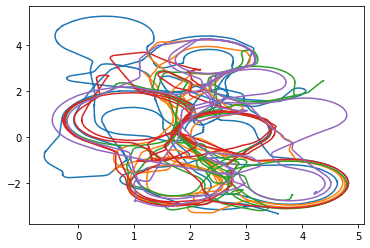

In [9]:
plt.plot(robot1_gt_x, robot1_gt_y)
plt.plot(robot2_gt_x, robot2_gt_y)
plt.plot(robot3_gt_x, robot3_gt_y)
plt.plot(robot4_gt_x, robot4_gt_y)
plt.plot(robot5_gt_x, robot5_gt_y)

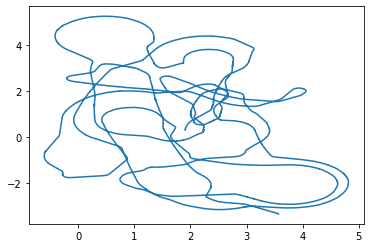

In [10]:
plt.plot(robot1_gt_x, robot1_gt_y)


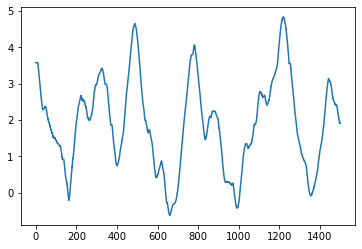

In [11]:
plt.plot(robot1_gt_time - robot1_gt_time[0], robot1_gt_x)


In [12]:
ts = robot1_gt_time[100] - robot1_gt_time[99] 
dx = robot1_gt_x[100] - robot1_gt_x[99]

In [13]:
dx/ts

-0.0007000016493032707

In [14]:
dx, ts

(-2.3800000000129273e-05, 0.03399991989135742)

In [15]:
robot1_gt_x

array([3.5732324, 3.5732247, 3.573238 , ..., 1.9074724, 1.9067457,
       1.9062726])

In [16]:
robot1_odo

,Time,Forward Velocity,Angular Velocity
0,1.248272e+09,0.074,0.229
1,1.248272e+09,0.074,0.229
2,1.248272e+09,0.074,0.229
3,1.248272e+09,0.074,0.229
4,1.248272e+09,0.074,0.229
5,1.248272e+09,0.074,0.230
6,1.248272e+09,0.074,0.230
7,1.248272e+09,0.074,0.229
8,1.248272e+09,0.074,0.229
9,1.248272e+09,0.074,0.229


## Helper Functions and Intialization Calculations

In [17]:
def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle

In [18]:
def generateBarcodeDictionary(filename):
    """
    """
    barcode_data = loadFile(filename)
    sub = barcode_data['Subject'].to_numpy()
    bar = barcode_data['Barcode'].to_numpy()
    
    bar_dict = {}
    
    for i in range(len(sub)):
        bar_dict[bar[i]] = sub[i]
        
    return bar_dict

In [19]:
barcode_dictionary = generateBarcodeDictionary("./MRCLAM_Dataset1/Barcodes.dat")
print(barcode_dictionary)

{5: 1, 14: 2, 41: 3, 32: 4, 23: 5, 72: 6, 27: 7, 54: 8, 70: 9, 36: 10, 18: 11, 25: 12, 9: 13, 81: 14, 16: 15, 90: 16, 61: 17, 45: 18, 7: 19, 63: 20}


In [20]:
def barcode2subject(barcode, barcode_dictionary):
    """
    """
    
    return barcode_dictionary[barcode]

In [21]:
barcode2subject(63, barcode_dictionary)

20

## Prediction Step Functions

In [22]:
def propogateState(x_t_prev, u_t, dt):
    """
    """
    angle = x_t_prev[2]
    
    A = np.eye(3)
    
    B = np.array([[dt*np.cos(angle), 0],
                  [dt*np.sin(angle), 0],
                  [0, dt]])
    
    x_bar_t = A@x_t_prev + B@u_t
    
    #correction with wrap to pi on the third element
    x_bar_t[2] = wrap_to_pi((A@x_t_prev)[2] + (B@u_t)[2])
    
    return x_bar_t

In [23]:
def getGx(x_t_prev, u_t, dt):
    """
    """
    v_t = u_t[0]
    angle = x_t_prev[2]
    
    Gx = np.array([[1, 0, -dt*v_t*np.sin(angle)],
                   [0, 1, dt*v_t*np.cos(angle)],
                   [0, 0, 1]])
    
    return Gx

In [24]:
def getGu(x_t_prev, u_t, dt):
    """
    """
    angle = x_t_prev[2]
    
    Gu = np.array([[dt*np.cos(angle), 0],
                   [dt*np.sin(angle), 0],
                   [0, dt]])
    
    return Gu

In [25]:
def predictionStep(x_t_prev, sigma_t_prev, u_t, sigma_u_t, dt):
    """
    """
    #propogate the state
    x_bar_t = propogateState(x_t_prev, u_t, dt)
    
    #get motion model jacobians
    Gx = getGx(x_t_prev, u_t, dt)
    Gu = getGu(x_t_prev, u_t, dt)
    
    #propagate the covariance matrix
    sigma_x_bar_t = Gx @ sigma_t_prev @ Gx.transpose() + Gu @ sigma_u_t @ Gu.transpose()
    
    return x_bar_t, sigma_x_bar_t

## Correction Step Functions

In [26]:
def getHt(x_bar_t):
    """
    """
    
    H_t = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
    
    return H_t

In [27]:
def getKalmanGain(sigma_x_bar_t, H_t, sigma_z_t):
    """
    """
    #calculate the denominator of the kalman gain
    denominator = np.linalg.inv(H_t @ sigma_x_bar_t @ H_t.transpose() + sigma_z_t)
    
    #finish the calculation
    K_t = sigma_x_bar_t @ H_t.transpose() @ denominator
    
    return K_t

In [28]:
def predMeasurement(x_bar_t):
    """
    """
    #using simulated yaw
    z_t_pred = x_bar_t
    
    
    return z_t_pred

In [29]:
def correctionStep(x_bar_t, sigma_x_bar_t, Z_t, sigma_z_t):
    """
    """
    #retrieve needed values for the calculation
    H_t = getHt(x_bar_t)
    K_t = getKalmanGain(sigma_x_bar_t, H_t, sigma_z_t)
    pred_meas = predMeasurement(x_bar_t)
    
    #correction step
    
#     print("x_bar_t: ", x_bar_t.shape)
#     print("K_t: ", K_t.shape)
#     print("Z_t: ", Z_t.shape)
#     print("pred_meas: ", pred_meas.shape)
    
    inter = Z_t - pred_meas
    inter[2] = wrap_to_pi((Z_t - pred_meas)[2])
    
    x_t = x_bar_t + K_t@(inter)
    #x_t = x_bar_t + K_t@(pred_meas - pred_meas)
    x_t[2] = wrap_to_pi(x_bar_t[2] + (K_t@(inter))[2]) #fix angle?
    
    sigma_x_t = (np.identity(len(x_t)) - K_t@H_t)@sigma_x_bar_t
    
    return x_t, sigma_x_t

## Main function and Related Helpers

In [30]:
def orderOfPredictionList(folder_name):
    """
    """
    
    robot1_odo = loadFile("./" + folder_name+ "/Robot1_Odometry.dat")
    robot2_odo = loadFile("./" + folder_name+ "/Robot2_Odometry.dat")
    robot3_odo = loadFile("./" + folder_name+ "/Robot3_Odometry.dat")
    robot4_odo = loadFile("./" + folder_name+ "/Robot4_Odometry.dat")
    robot5_odo = loadFile("./" + folder_name+ "/Robot5_Odometry.dat")
    
    ts_1 = robot1_odo.to_numpy()
    ts_2 = robot2_odo.to_numpy()
    ts_3 = robot3_odo.to_numpy()
    ts_4 = robot4_odo.to_numpy()
    ts_5 = robot5_odo.to_numpy()
    
    LoTs = [ts_1, ts_2, ts_3, ts_4, ts_5]
    Tuple_list = []
    
    for robot in range(5):
        currList = LoTs[robot]
        for t in range(len(currList)):
            Tuple_list.append((currList[t][0], robot, currList[t][1], currList[t][2]))
            
    Tuple_list.sort()
    
    return Tuple_list, [len(ts_1), len(ts_2), len(ts_3), len(ts_4), len(ts_5)]
    

In [31]:
odoTS, odoTSLen = orderOfPredictionList("MRCLAM_Dataset1")

In [32]:
def groundTruthLandmarksDict(folder_name):
    
    # col_name = ['Subject', 'x', 'y', 'x_std', 'y_std']
    landmark_gt = loadFile("./" + folder_name + "/Landmark_Groundtruth.dat")
    
    landmark_dict = {}
    
    subject = landmark_gt['Subject'].to_numpy()
    x = landmark_gt['x'].to_numpy()
    y = landmark_gt['y'].to_numpy()
    x_std = landmark_gt['x_std'].to_numpy()
    y_std = landmark_gt['y_std'].to_numpy()
    
    for i in range(len(subject)):
        landmark_dict[subject[i]] = (x[i], y[i], x_std[i], y_std[i])
        
    return landmark_dict
    
    

In [33]:
landmark_dictionary = groundTruthLandmarksDict('MRCLAM_Dataset1')

In [34]:
def groundTruthDataDict(folder_name):
    '''
    NOTE: ROBOT IS ZERO INDEXED SO Robot = subject - 1
    '''
    
    robot1_gt = loadFile("./" + folder_name + "/Robot1_Groundtruth.dat")
    robot2_gt = loadFile("./" + folder_name + "/Robot2_Groundtruth.dat")
    robot3_gt = loadFile("./" + folder_name + "/Robot3_Groundtruth.dat")
    robot4_gt = loadFile("./" + folder_name + "/Robot4_Groundtruth.dat")
    robot5_gt = loadFile("./" + folder_name + "/Robot5_Groundtruth.dat")
    
    gt_dict = {}
    
    # NOTE: ROBOT IS ZERO INDEXED SO Robot = subject - 1
    gt_dict[0] = robot1_gt.to_numpy()
    gt_dict[1] = robot2_gt.to_numpy()
    gt_dict[2] = robot3_gt.to_numpy()
    gt_dict[3] = robot4_gt.to_numpy()
    gt_dict[4] = robot5_gt.to_numpy()
    
    return gt_dict
    

In [35]:
gt_dictionary = groundTruthDataDict('MRCLAM_Dataset1')

In [36]:
def getInitialState(folder_name, numRobots = 5, numStates = 3):
    
    robot1_gt = loadFile("./" + folder_name+ "/Robot1_Groundtruth.dat")
    robot2_gt = loadFile("./" + folder_name+ "/Robot2_Groundtruth.dat")
    robot3_gt = loadFile("./" + folder_name+ "/Robot3_Groundtruth.dat")
    robot4_gt = loadFile("./" + folder_name+ "/Robot4_Groundtruth.dat")
    robot5_gt = loadFile("./" + folder_name+ "/Robot5_Groundtruth.dat")
    
    robot1_gt_x = robot1_gt['x'].to_numpy()
    robot2_gt_x = robot2_gt['x'].to_numpy()
    robot3_gt_x = robot3_gt['x'].to_numpy()
    robot4_gt_x = robot4_gt['x'].to_numpy()
    robot5_gt_x = robot5_gt['x'].to_numpy()

    robot1_gt_y = robot1_gt['y'].to_numpy()
    robot2_gt_y = robot2_gt['y'].to_numpy()
    robot3_gt_y = robot3_gt['y'].to_numpy()
    robot4_gt_y = robot4_gt['y'].to_numpy()
    robot5_gt_y = robot5_gt['y'].to_numpy()
    
    robot1_gt_yaw = robot1_gt['orientation'].to_numpy()
    robot2_gt_yaw = robot2_gt['orientation'].to_numpy()
    robot3_gt_yaw = robot3_gt['orientation'].to_numpy()
    robot4_gt_yaw = robot4_gt['orientation'].to_numpy()
    robot5_gt_yaw = robot5_gt['orientation'].to_numpy()
    
    initialStates = np.zeros((numRobots, numStates))
    
    initialStates[0] = np.array([robot1_gt_x[0], robot1_gt_y[0], robot1_gt_yaw[0]])
    initialStates[1] = np.array([robot2_gt_x[0], robot2_gt_y[0], robot2_gt_yaw[0]])
    initialStates[2] = np.array([robot3_gt_x[0], robot3_gt_y[0], robot3_gt_yaw[0]])
    initialStates[3] = np.array([robot4_gt_x[0], robot4_gt_y[0], robot4_gt_yaw[0]])
    initialStates[4] = np.array([robot5_gt_x[0], robot5_gt_y[0], robot5_gt_yaw[0]])
    
    return initialStates
    
    

In [37]:
def getMeasurements(folder_name, acceptedBarcodes):
    
    #load in all the measurement data
    robot1_meas = loadFile("./" + folder_name + "/Robot1_Measurement.dat").to_numpy()
    robot2_meas = loadFile("./" + folder_name + "/Robot2_Measurement.dat").to_numpy()
    robot3_meas = loadFile("./" + folder_name + "/Robot3_Measurement.dat").to_numpy()
    robot4_meas = loadFile("./" + folder_name + "/Robot4_Measurement.dat").to_numpy()
    robot5_meas = loadFile("./" + folder_name + "/Robot5_Measurement.dat").to_numpy()
    
    #initialize logical index vectors for acceptable barcodes
    logicalIdx1 = np.zeros(len(robot1_meas), dtype = bool)
    logicalIdx2 = np.zeros(len(robot2_meas), dtype = bool)
    logicalIdx3 = np.zeros(len(robot3_meas), dtype = bool)
    logicalIdx4 = np.zeros(len(robot4_meas), dtype = bool)
    logicalIdx5 = np.zeros(len(robot5_meas), dtype = bool)
    
    for i in range(len(acceptedBarcodes)):
        logicalIdx1 = logicalIdx1 | (robot1_meas[:,1] == acceptedBarcodes[i])
        logicalIdx2 = logicalIdx2 | (robot2_meas[:,1] == acceptedBarcodes[i])
        logicalIdx3 = logicalIdx3 | (robot3_meas[:,1] == acceptedBarcodes[i])
        logicalIdx4 = logicalIdx4 | (robot4_meas[:,1] == acceptedBarcodes[i])
        logicalIdx5 = logicalIdx5 | (robot5_meas[:,1] == acceptedBarcodes[i])
        
    
    #load in the ground truth values and convert to numpy
    robot1_gt = loadFile("./" + folder_name+ "/Robot1_Groundtruth.dat").to_numpy()
    robot2_gt = loadFile("./" + folder_name+ "/Robot2_Groundtruth.dat").to_numpy()
    robot3_gt = loadFile("./" + folder_name+ "/Robot3_Groundtruth.dat").to_numpy()
    robot4_gt = loadFile("./" + folder_name+ "/Robot4_Groundtruth.dat").to_numpy()
    robot5_gt = loadFile("./" + folder_name+ "/Robot5_Groundtruth.dat").to_numpy()
    
    #scrub unecessary data from measurement vectors
    robot1_meas = robot1_meas[logicalIdx1]
    robot2_meas = robot2_meas[logicalIdx2]
    robot3_meas = robot3_meas[logicalIdx3] 
    robot4_meas = robot4_meas[logicalIdx4]
    robot5_meas = robot5_meas[logicalIdx5]
    
    List_of_meas = [robot1_meas, robot2_meas, robot3_meas, robot4_meas, robot5_meas]
    List_of_gt = [robot1_gt, robot2_gt, robot3_gt, robot4_gt, robot5_gt]
    
    
    #set the seed to get repeatable results
    np.random.seed(0)
    
    for i in range(len(List_of_meas)):
        
        temp = np.array([getClosestYaw(List_of_gt[i], curTS) for curTS in List_of_meas[i][:, 0]])
        rand_noise = np.random.normal(loc = 0, scale = np.sqrt(0.1), size = temp.shape)
        temp += rand_noise
        List_of_meas[i] = np.concatenate((List_of_meas[i], temp.reshape(len(temp), 1)), axis = 1)
        
    
    
    return List_of_meas[0], List_of_meas[1], List_of_meas[2], List_of_meas[3], List_of_meas[4]
    

In [38]:
def getClosestYaw(gt_data, curTS):
    '''
    Assuming we're passing in the right gt_data for the robot
    
    NOTE: ROBOT IS ZERO INDEXED SO Robot = subject - 1
    '''
    
    timestamps = gt_data[:, 0]
    
    calcAbsDiff = np.abs(timestamps - curTS)
    closestIdx = np.argmin(calcAbsDiff)
    
    closestYaw = gt_data[closestIdx, 3]
    
    return closestYaw
    

In [39]:
test = getMeasurements('MRCLAM_Dataset1', [72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63])

In [40]:
test[0][0]

array([1.24827228e+09, 9.00000000e+01, 2.14800000e+00, 2.50000000e-02,
       3.07594233e+00])

In [41]:
def checkForMeasurement(robotMeasurement, prevTS, curTS, curMeasurementIdx):
    '''
    prevTS = curTS (?)
    curTS = curTS + DT (?)
    NOTE: don't use that
    '''
    
    validMeasurements = (robotMeasurement[:,0] >= prevTS) & (robotMeasurement[:,0] <= curTS)
    
    if not np.any(validMeasurements):
        return False, validMeasurements, curMeasurementIdx
    
    return True, validMeasurements, curMeasurementIdx + np.sum(validMeasurements)

In [42]:
def convertMeasurements(robotMeasurements, robotStates, predictionTimes, robotIdx, measIdx, predAngle, barcode_dictionary, landmark_dictionary):
    """
    """
    
    
    measurements = robotMeasurements[measIdx]
    
    numMeasurements = len(measurements)
    
    
    Zx = 0
    Zy = 0
    Zt = measurements[-1][4]
    for i in range(numMeasurements):
        
        #retrieve the state estimate of x, y for the measured entity
        subject = barcode2subject(measurements[i][1], barcode_dictionary)
        
        if subject < 6:
            subject = subject - 1 # ROBOT IS ZERO INDEXED
            measX = robotStates[subject][0]
            measY = robotStates[subject][1]
            
        else:
            measX, measY, _, _ = landmark_dictionary[subject]

#         print("thing:", measurements[i][2])
#         print("measRobotX: ", measRobotX)
        
        angle = wrap_to_pi(predAngle + measurements[i][3])
        Zx += measX - measurements[i][2]*np.cos(angle)
        Zy += measY - measurements[i][2]*np.sin(angle)
        
#     print("Zx: ", Zx)
#     print("Zy: ", Zy)
        
    Zx = Zx / numMeasurements
    Zy = Zy / numMeasurements
    
    #TODO: put in measurement at start, check that return value makes sense
    #todo: check signs
    
    return np.array([Zx, Zy, Zt])

In [43]:
measX = 5.70928255 
measY = 4.96404466

#robot is at 0, 0, 0
Zx = 0
Zy = 0
predAngle = 0
bearing = 41*np.pi/180
angle = wrap_to_pi(predAngle + bearing)
rangeMeas = 7.7656
Zx += measX - rangeMeas*np.cos(angle)
Zy += measY - rangeMeas*np.sin(angle)
print(Zx, Zy)

-0.1514901661779584 -0.1306473355286828


In [44]:
def getSigmaU(robot):
    """
    """
    
    sigma = np.eye(2)*0.1
    return sigma

In [45]:
def getSigmaZ(robot):
    """
    """
    sigma = np.eye(3)*0.1
    return sigma

In [46]:
def getError(robot_gt, robot_est, robot_ts):
    
    gt_idx = 0
    gt_timestamps = robot_gt[:,0]
    
    x_error = np.zeros(len(robot_ts))
    y_error = np.zeros(len(robot_ts))
    theta_error = np.zeros(len(robot_ts))
    euclidean_error = np.zeros(len(robot_ts))
    
    for i in range(len(robot_ts)):
        curTS = robot_ts[i]
                
        calcAbsDiff = np.abs(gt_timestamps - curTS)
        gt_idx = np.argmin(calcAbsDiff)

        _, x_gt, y_gt, theta_gt = robot_gt[gt_idx]
        x, y, theta = robot_est[:, i]

        x_error[i] = x - x_gt
        y_error[i] = y - y_gt
        theta_error[i] = theta - theta_gt
#         print()
#         print('curTS ', curTS)
#         print('gt_idx ', gt_idx)
#         print('x_gt: ', x_gt)
#         print('y_gt: ', y_gt)
#         print('theta gt: ', theta_gt)
#         print()

        euclidean_error[i] = np.sqrt(np.square(x - x_gt) + np.square(y - y_gt))
    
        gt_timestamps = gt_timestamps[gt_idx:]
        robot_gt = robot_gt[gt_idx:]
        
    return x_error, y_error, theta_error, euclidean_error

In [47]:
def calcRMSE(residuals):
    """
    """
    
    RMSE = np.sum(np.square(residuals))/len(residuals)
    return RMSE

In [95]:
def main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, barcodes):
    """
    """
    
    last_timestep = np.zeros(5)
    
    #dt = 1/67 # May be changed later
    
    # Initialize States and Covars
    N = 3 # Number of states
    numRobots = 5
    
    numSteps = len(odoTS)
    #numSteps = 10000
    
    state_est_t_prev = getInitialState("MRCLAM_Dataset1", numRobots, N)
    var_est_t_prev = np.array([np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)]) # Hardcoded for 5 robots
    
    log_idx = np.zeros(numRobots, dtype=int)
    state_estimates = {}
    covariance_estimates = {}
    timesMoreMeas = 0
    
    est_times = {}
#     est_times[0] = []
#     est_times[1] = []
#     est_times[2] = []
#     est_times[3] = []
#     est_times[4] = []
    measuredCorrections = {}
    meas_log = {}
    
    for i in range(numRobots):
        # Initialize state and covar logs for each robot
        stateLogRobotI = np.empty((N, odoTSLen[i]))
        covarLogRobotI = np.empty((N, N, odoTSLen[i]))
        
        # Throw them into the dictionary and cry
        state_estimates[i] = stateLogRobotI
        covariance_estimates[i] = covarLogRobotI
        est_times[i] = np.empty(odoTSLen[i])
        measuredCorrections[i] = np.zeros(odoTSLen[i], dtype = bool)
        meas_log[i] = list()
    
    # robots: 5, 14, 41, 32, 23, 
    # landmarks: 72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63
    measurements = getMeasurements('MRCLAM_Dataset1', barcodes)
    nextMeasurementIndex = np.zeros(5)
    #prevMeasurements = np.ones((numRobots, N-1))*np.inf
    

    
    for i in range(numSteps):

            
        curTS, robot, v, w = odoTS[i]
#         est_times[robot].append(curTS)
        
        # Making dt variable
        if last_timestep[robot] == 0:
            dt = 1/67
        else:
            dt = curTS - last_timestep[robot]
                    
        # Prediction Step
        u_t = np.array([v, w])
        sigma_u_t = getSigmaU(robot)
        x_bar_t, sigma_x_bar_t = predictionStep(state_est_t_prev[robot], var_est_t_prev[robot], u_t, sigma_u_t, dt)
        
        # Correction Step
        # Check if measurement is between last and curTS
        
        meas_exists, validMeasurements, nextMeasurementIndex[robot] = checkForMeasurement(measurements[robot], last_timestep[robot], curTS, nextMeasurementIndex[robot])

        if meas_exists: #False: # 
            
            if np.sum(validMeasurements) > 1:
                timesMoreMeas += 1
            
            #fuse measurements together
            Z_t = convertMeasurements(measurements[robot], state_est_t_prev, last_timestep, robot, validMeasurements, x_bar_t[2], barcode_dictionary, landmark_dictionary)
                    
                
            #skip "broken" measurements
            if(np.abs(x_bar_t[0] - Z_t[0]) > 1 or np.abs(x_bar_t[1] - Z_t[1]) > 1):
                
                #estiamte is just the prediction 
                x_t = x_bar_t
                sigma_x_t = sigma_x_bar_t
                
            #else - default case
            else:
                
                #get designated meas covar
                sigma_z_t = getSigmaZ(robot)

                #perform corretion step
                x_t, sigma_x_t = correctionStep(x_bar_t, sigma_x_bar_t, Z_t, sigma_z_t)

                measuredCorrections[robot][log_idx[robot]] = True
                
                meas_log[robot].append((curTS, Z_t[0], Z_t[1]))
                
                #prevMeasurements[robot] = Z_t
                
            
        else:
            
            #estiamte is just the prediction 
            x_t = x_bar_t
            sigma_x_t = sigma_x_bar_t
            
        # For shits and giggles let's use gt yaw
        x_t[2] = getClosestYaw(gt_dictionary[robot], curTS)
            
        #update last time step
        last_timestep[robot] = curTS
        
        
        #update prev vectors
        state_est_t_prev[robot] = x_t
        var_est_t_prev[robot] = sigma_x_t
        
        #log data
        state_estimates[robot][:, log_idx[robot]] = x_t
        covariance_estimates[robot][:,:,log_idx[robot]] = sigma_x_t
        est_times[robot][log_idx[robot]] = curTS
        
        #increment log tracker
        log_idx[robot] += 1
        
    print(timesMoreMeas)

    return state_estimates, covariance_estimates, est_times, measuredCorrections, meas_log
        

In [49]:
#states, covars, est_times, measuredCorrections, meas_log = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary)

5874


In [ ]:
# robots: 5, 14, 41, 32, 23, 
# landmarks: 72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63

# Jimmy: everything but just robots and landmarks 1-3
# Christina: Just robots and landmarks 1-3

justLandmarks = [72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63]
justRobots = [5, 14, 41, 32, 23]
allAvailable = [5, 14, 41, 32, 23, 72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63]

numLand_1 = [5, 14, 41, 32, 23, 72]
numLand_2 = [5, 14, 41, 32, 23, 72, 27]
numLand_3 = [5, 14, 41, 32, 23, 72, 27, 54]
numLand_4 = [5, 14, 41, 32, 23, 72, 27, 54, 70]
numLand_5 = [5, 14, 41, 32, 23, 72, 27, 54, 70, 36]

numLand_10 = [5, 14, 41, 32, 23, 72, 27, 54, 70, 36, 18, 25, 9, 81, 16]


states_justL, covars_justL, est_times_justL, measuredCorrections_justL, meas_log_justL = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, justLandmarks)
states_justR, covars_justR, est_times_justR, measuredCorrections_justR, meas_log_justR = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, justRobots)
states_all, covars_all, est_times_all, measuredCorrections_all, meas_log_all = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, allAvailable)

states_1, covars_1, est_times_1, measuredCorrections_1, meas_log_1 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_1)
states_2, covars_2, est_times_2, measuredCorrections_2, meas_log_2 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_2)
states_3, covars_3, est_times_3, measuredCorrections_3, meas_log_3 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_3)
states_4, covars_4, est_times_4, measuredCorrections_4, meas_log_4 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_4)
states_5, covars_5, est_times_5, measuredCorrections_5, meas_log_5 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_5)

states_10, covars_10, est_times_10, measuredCorrections_10, meas_log_10 = main(odoTS, odoTSLen, barcode_dictionary, landmark_dictionary, gt_dictionary, numLand_10)

TO UPDATE FOR YAW MEASUREMENT SIMULATION
- precalculate all simulated measurements of yaw, append to every measurement vector
- change correction step
- Ht, zt, pred measurement, etc

Experiments
- Just landmarks
- Just robots
- 1 through 5 landmarks (5 experiments)
- 10 landmarks
- 15 landmarks (all Available)

In [50]:
#flagging timesteps

ts_jumps = {}
thresh = (1/67)*25

for i in range(5):
    t = est_times[i]
    diffs = t[1:] - t[:-1]
    ts_jumps[i] = diffs > thresh 
    temp = np.zeros(len(ts_jumps[i]) + 1, dtype = bool)
    temp[1:] = ts_jumps[i]
    ts_jumps[i] = temp
    print(np.sum(ts_jumps[i]))
    
print(ts_jumps[i])

17
5
8
75
10
[False False False ... False False False]


In [100]:
def getErrorAllRobots(states, est_times):
    
    robot1_gt = loadFile("./MRCLAM_Dataset1/Robot1_Groundtruth.dat")
    robot2_gt = loadFile("./MRCLAM_Dataset1/Robot2_Groundtruth.dat")
    robot3_gt = loadFile("./MRCLAM_Dataset1/Robot3_Groundtruth.dat")
    robot4_gt = loadFile("./MRCLAM_Dataset1/Robot4_Groundtruth.dat")
    robot5_gt = loadFile("./MRCLAM_Dataset1/Robot5_Groundtruth.dat")

    robot1_gt_np = robot1_gt.to_numpy()
    robot2_gt_np = robot2_gt.to_numpy()
    robot3_gt_np = robot3_gt.to_numpy()
    robot4_gt_np = robot4_gt.to_numpy()
    robot5_gt_np = robot5_gt.to_numpy()
    
    r1 = getError(robot1_gt_np, states[0], est_times[0])
    r2 = getError(robot2_gt_np, states[1], est_times[1])
    r3 = getError(robot3_gt_np, states[2], est_times[2])
    r4 = getError(robot4_gt_np, states[3], est_times[3])
    r5 = getError(robot5_gt_np, states[4], est_times[4])
    
    errorDict = {1:r1, 2:r2, 3:r3, 4:r4, 5:r5}
    
    return errorDict


In [102]:
def printSummaryAllRobots(errorDict):
    
    r1_x, r1_y, r1_theta, r1_euc = errorDict[1]
    r2_x, r2_y, r2_theta, r2_euc = errorDict[2]
    r3_x, r3_y, r3_theta, r3_euc = errorDict[3]
    r4_x, r4_y, r4_theta, r4_euc = errorDict[4]
    r5_x, r5_y, r5_theta, r5_euc = errorDict[5]
    
    #robot 1 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
    print("robot 1 X RMSE: ", calcRMSE(r1_x))
    print("robot 1 Y RMSE: ", calcRMSE(r1_y))
    print("robot 1 theta RMSE: ", calcRMSE(r1_theta))
    print("robot 1 euc RMSE: ", calcRMSE(r1_euc))
    print()

    #robot 2 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
    print("robot 2 X RMSE: ", calcRMSE(r2_x))
    print("robot 2 Y RMSE: ", calcRMSE(r2_y))
    print("robot 2 theta RMSE: ", calcRMSE(r2_theta))
    print("robot 2 euc RMSE: ", calcRMSE(r2_euc))
    print()

    #robot 3 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
    print("robot 3 X RMSE: ", calcRMSE(r3_x))
    print("robot 3 Y RMSE: ", calcRMSE(r3_y))
    print("robot 3 theta RMSE: ", calcRMSE(r3_theta))
    print("robot 3 euc RMSE: ", calcRMSE(r3_euc))
    print()

    #robot 4 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
    print("robot 4 X RMSE: ", calcRMSE(r4_x))
    print("robot 4 Y RMSE: ", calcRMSE(r4_y))
    print("robot 4 theta RMSE: ", calcRMSE(r4_theta))
    print("robot 4 euc RMSE: ", calcRMSE(r4_euc))
    print()

    #robot 5 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
    print("robot 5 X RMSE: ", calcRMSE(r5_x))
    print("robot 5 Y RMSE: ", calcRMSE(r5_y))
    print("robot 5 theta RMSE: ", calcRMSE(r5_theta))
    print("robot 5 euc RMSE: ", calcRMSE(r5_euc))

In [110]:
errorDict = getErrorAllRobots(states, est_times)

In [51]:
# def getError(robot_gt, robot_est, robot_ts):
robot1_gt = loadFile("./MRCLAM_Dataset1/Robot1_Groundtruth.dat")
robot2_gt = loadFile("./MRCLAM_Dataset1/Robot2_Groundtruth.dat")
robot3_gt = loadFile("./MRCLAM_Dataset1/Robot3_Groundtruth.dat")
robot4_gt = loadFile("./MRCLAM_Dataset1/Robot4_Groundtruth.dat")
robot5_gt = loadFile("./MRCLAM_Dataset1/Robot5_Groundtruth.dat")

robot1_gt_np = robot1_gt.to_numpy()
robot2_gt_np = robot2_gt.to_numpy()
robot3_gt_np = robot3_gt.to_numpy()
robot4_gt_np = robot4_gt.to_numpy()
robot5_gt_np = robot5_gt.to_numpy()


r1_x, r1_y, r1_theta, r1_euc = getError(robot1_gt_np, states[0], est_times[0])
r2_x, r2_y, r2_theta, r2_euc = getError(robot2_gt_np, states[1], est_times[1])
r3_x, r3_y, r3_theta, r3_euc = getError(robot3_gt_np, states[2], est_times[2])
r4_x, r4_y, r4_theta, r4_euc = getError(robot4_gt_np, states[3], est_times[3])
r5_x, r5_y, r5_theta, r5_euc = getError(robot5_gt_np, states[4], est_times[4])

In [52]:
#robot 1 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
print("robot 1 X RMSE: ", calcRMSE(r1_x))
print("robot 1 Y RMSE: ", calcRMSE(r1_y))
print("robot 1 theta RMSE: ", calcRMSE(r1_theta))
print("robot 1 euc RMSE: ", calcRMSE(r1_euc))
print()

#robot 2 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
print("robot 2 X RMSE: ", calcRMSE(r2_x))
print("robot 2 Y RMSE: ", calcRMSE(r2_y))
print("robot 2 theta RMSE: ", calcRMSE(r2_theta))
print("robot 2 euc RMSE: ", calcRMSE(r2_euc))
print()

#robot 3 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
print("robot 3 X RMSE: ", calcRMSE(r3_x))
print("robot 3 Y RMSE: ", calcRMSE(r3_y))
print("robot 3 theta RMSE: ", calcRMSE(r3_theta))
print("robot 3 euc RMSE: ", calcRMSE(r3_euc))
print()

#robot 4 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
print("robot 4 X RMSE: ", calcRMSE(r4_x))
print("robot 4 Y RMSE: ", calcRMSE(r4_y))
print("robot 4 theta RMSE: ", calcRMSE(r4_theta))
print("robot 4 euc RMSE: ", calcRMSE(r4_euc))
print()

#robot 5 RMSE values. NOTE: GT theta is not wrapped, RMSE is probably inflated
print("robot 5 X RMSE: ", calcRMSE(r5_x))
print("robot 5 Y RMSE: ", calcRMSE(r5_y))
print("robot 5 theta RMSE: ", calcRMSE(r5_theta))
print("robot 5 euc RMSE: ", calcRMSE(r5_euc))

robot 1 X RMSE:  0.006992186125272085
robot 1 Y RMSE:  0.0076860962308861495
robot 1 theta RMSE:  0.0
robot 1 euc RMSE:  0.01467828235615823

robot 2 X RMSE:  0.004765641067385389
robot 2 Y RMSE:  0.00792576103449307
robot 2 theta RMSE:  0.0
robot 2 euc RMSE:  0.012691402101878461

robot 3 X RMSE:  0.004002597101015417
robot 3 Y RMSE:  0.013523210759900059
robot 3 theta RMSE:  0.0
robot 3 euc RMSE:  0.017525807860915475

robot 4 X RMSE:  0.006148806327810851
robot 4 Y RMSE:  0.01373434814713633
robot 4 theta RMSE:  0.0
robot 4 euc RMSE:  0.019883154474947182

robot 5 X RMSE:  0.007280323966775426
robot 5 Y RMSE:  0.015710881605317275
robot 5 theta RMSE:  0.0
robot 5 euc RMSE:  0.022991205572092697


In [112]:
printSummaryAllRobots(errorDict)

robot 1 X RMSE:  0.006992186125272085
robot 1 Y RMSE:  0.0076860962308861495
robot 1 theta RMSE:  0.0
robot 1 euc RMSE:  0.01467828235615823

robot 2 X RMSE:  0.004765641067385389
robot 2 Y RMSE:  0.00792576103449307
robot 2 theta RMSE:  0.0
robot 2 euc RMSE:  0.012691402101878461

robot 3 X RMSE:  0.004002597101015417
robot 3 Y RMSE:  0.013523210759900059
robot 3 theta RMSE:  0.0
robot 3 euc RMSE:  0.017525807860915475

robot 4 X RMSE:  0.006148806327810851
robot 4 Y RMSE:  0.01373434814713633
robot 4 theta RMSE:  0.0
robot 4 euc RMSE:  0.019883154474947182

robot 5 X RMSE:  0.007280323966775426
robot 5 Y RMSE:  0.015710881605317275
robot 5 theta RMSE:  0.0
robot 5 euc RMSE:  0.022991205572092697


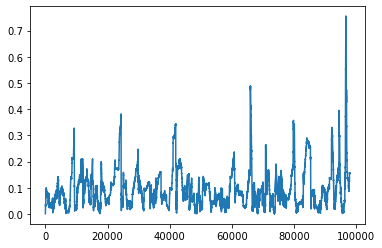

In [53]:
plt.plot(r1_euc)

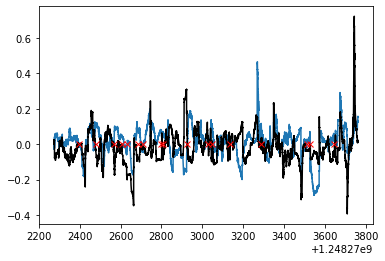

In [54]:
plt.plot(est_times[0], r1_x)
plt.plot(est_times[0], r1_y, "k")
plt.plot(est_times[0][ts_jumps[0]], np.zeros(len(est_times[0][ts_jumps[0]])) ,"rx")

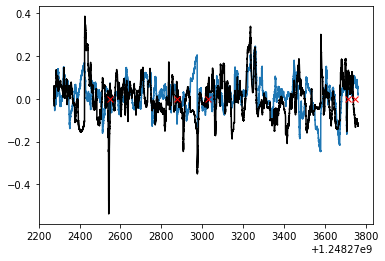

In [55]:
plt.plot(est_times[1], r2_x)
plt.plot(est_times[1], r2_y, "k")
plt.plot(est_times[1][ts_jumps[1]], np.zeros(len(est_times[1][ts_jumps[1]])) ,"rx")

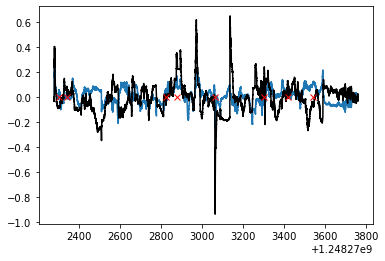

In [56]:
plt.plot(est_times[2], r3_x)
plt.plot(est_times[2], r3_y, "k")
plt.plot(est_times[2][ts_jumps[2]], np.zeros(len(est_times[2][ts_jumps[2]])) ,"rx")

Text(0, 0.5, 'Error')

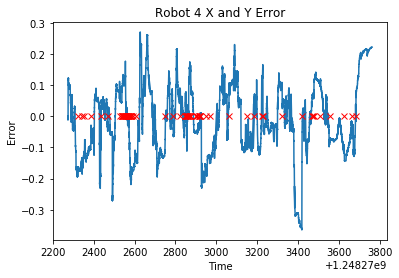

In [57]:
#plt.plot(est_times[3], r4_x)
plt.plot(est_times[3], r4_y)
#plt.plot(est_times[3][measuredCorrections[3]], np.zeros(len(est_times[3][measuredCorrections[3]])) ,"rx")
plt.plot(est_times[3][ts_jumps[3]], np.zeros(len(est_times[3][ts_jumps[3]])) ,"rx")

# plt.xlim([1248273500, 1248273600])
# print(plt.axis())

plt.title('Robot 4 X and Y Error')
plt.xlabel('Time')
plt.ylabel('Error')
#plt.legend(['X Error', 'Y Error'])

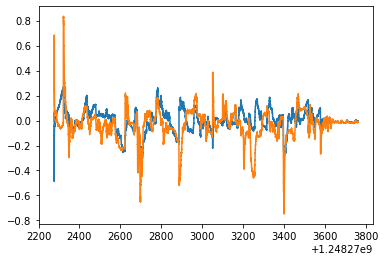

In [58]:
plt.plot(est_times[4], r5_x)
plt.plot(est_times[4], r5_y)

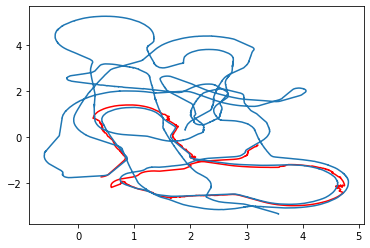

In [59]:
start = 20000
to = 40000
plt.plot(states[0][0][start:to], states[0][1][start:to], "r")
plt.plot(robot1_gt_x, robot1_gt_y)

# Plotting Function

In [114]:
def plotting(states, est_times, errorDict):
    
    # Plot overlay plots
    plt.figure(1)
    plt.plot(states[0][0], states[0][1], "r")
    plt.plot(robot1_gt_x, robot1_gt_y)
    plt.xlabel('X Pos (m)')
    plt.ylabel('Y Pos (m)')
    plt.legend(['Estimated Position', 'Groundtruth Position'])
    plt.title('Robot 1 Estimated Position')

    plt.figure(2)
    plt.plot(states[1][0], states[1][1], "r")
    plt.plot(robot2_gt_x, robot2_gt_y)
    plt.xlabel('X Pos (m)')
    plt.ylabel('Y Pos (m)')
    plt.legend(['Estimated Position', 'Groundtruth Position'])
    plt.title('Robot 2 Estimated Position')
    
    plt.figure(3)
    plt.plot(states[2][0], states[2][1], "r")
    plt.plot(robot3_gt_x, robot3_gt_y)
    plt.xlabel('X Pos (m)')
    plt.ylabel('Y Pos (m)')
    plt.legend(['Estimated Position', 'Groundtruth Position'])
    plt.title('Robot 3 Estimated Position')

    plt.figure(4)
    plt.plot(states[3][0], states[3][1], "r")
    plt.plot(robot4_gt_x, robot4_gt_y)
    plt.xlabel('X Pos (m)')
    plt.ylabel('Y Pos (m)')
    plt.legend(['Estimated Position', 'Groundtruth Position'])
    plt.title('Robot 4 Estimated Position')

    plt.figure(5)
    plt.plot(states[4][0], states[4][1], "r")
    plt.plot(robot5_gt_x, robot5_gt_y)
    plt.xlabel('X Pos (m)')
    plt.ylabel('Y Pos (m)')
    plt.legend(['Estimated Position', 'Groundtruth Position'])
    plt.title('Robot 5 Estimated Position')
    
    # Plot Euclidean distance error
    r1_x, r1_y, r1_theta, r1_euc = errorDict[1]
    r2_x, r2_y, r2_theta, r2_euc = errorDict[2]
    r3_x, r3_y, r3_theta, r3_euc = errorDict[3]
    r4_x, r4_y, r4_theta, r4_euc = errorDict[4]
    r5_x, r5_y, r5_theta, r5_euc = errorDict[5]
    
    plt.figure(6)
    plt.plot(est_times[0] - est_times[0][0], r1_euc)
    plt.xlabel('Time (s)')
    plt.ylabel('Euclidean Distance Error (m)')
    plt.title('Euclidean Distance Error Over Time for Robot 1')
    
    plt.figure(7)
    plt.plot(est_times[1] - est_times[1][0], r2_euc)
    plt.xlabel('Time (s)')
    plt.ylabel('Euclidean Distance Error (m)')
    plt.title('Euclidean Distance Error Over Time for Robot 2')
    
    plt.figure(8)
    plt.plot(est_times[2] - est_times[2][0], r3_euc)
    plt.xlabel('Time (s)')
    plt.ylabel('Euclidean Distance Error (m)')
    plt.title('Euclidean Distance Error Over Time for Robot 3')
    
    plt.figure(9)
    plt.plot(est_times[3] - est_times[3][0], r4_euc)
    plt.xlabel('Time (s)')
    plt.ylabel('Euclidean Distance Error (m)')
    plt.title('Euclidean Distance Error Over Time for Robot 4')
    
    plt.figure(10)
    plt.plot(est_times[4] - est_times[4][0], r5_euc)
    plt.xlabel('Time (s)')
    plt.ylabel('Euclidean Distance Error (m)')
    plt.title('Euclidean Distance Error Over Time for Robot 5')

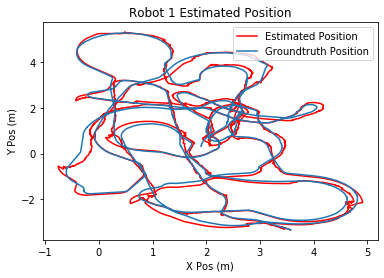

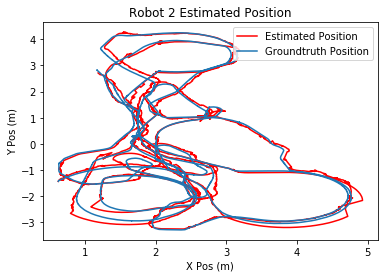

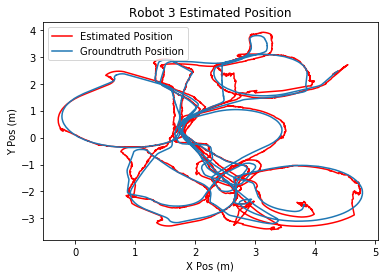

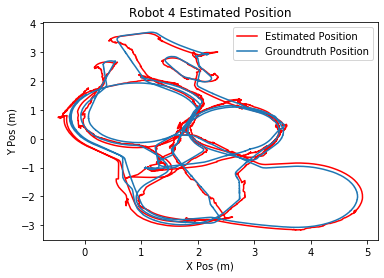

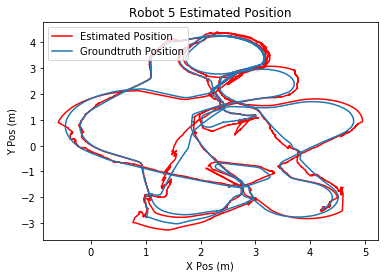

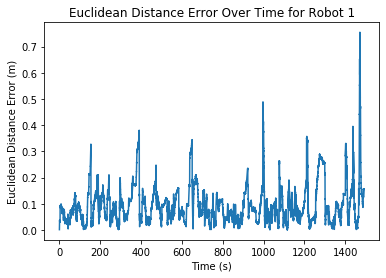

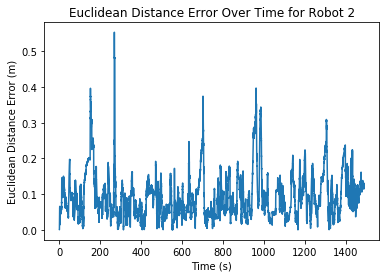

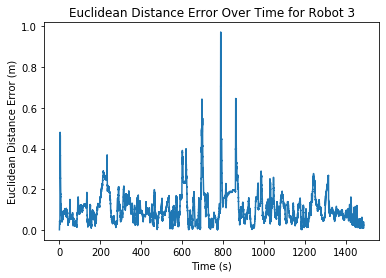

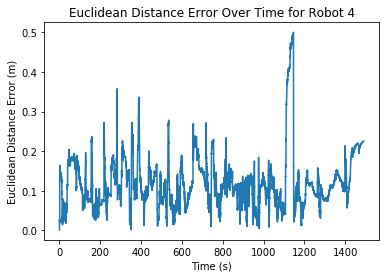

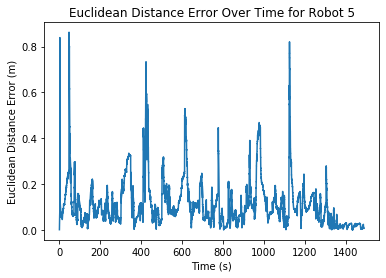

In [115]:
plotting(states, est_times, errorDict)

## Ground Truth Plots

In [60]:
gt1 = robot1_gt.to_numpy()
gt2 = robot2_gt.to_numpy()
gt3 = robot3_gt.to_numpy()
gt4 = robot4_gt.to_numpy()
gt5 = robot5_gt.to_numpy()

In [61]:
#[item[0] for item in meas_log[3]]

Text(0, 0.5, 'Position X (m)')

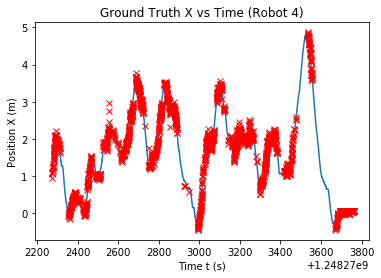

In [62]:
plt.plot(gt4[:, 0], gt4[:, 1]) #plot x vs t
plt.plot([item[0] for item in meas_log[3]], [item[1] for item in meas_log[3]], "rx")
plt.title("Ground Truth X vs Time (Robot 4)")
plt.xlabel("Time t (s)")
plt.ylabel("Position X (m)")
# plt.plot(est_times[3], r4_x, "r")
# plt.plot(est_times[3], r4_y, "k")

Text(0, 0.5, 'Position Y (m)')

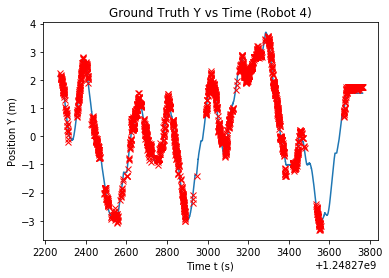

In [63]:
plt.plot(gt4[:, 0], gt4[:, 2]) #plot y vs t
plt.plot([item[0] for item in meas_log[3]], [item[2] for item in meas_log[3]], "rx")
plt.title("Ground Truth Y vs Time (Robot 4)")
plt.xlabel("Time t (s)")
plt.ylabel("Position Y (m)")
# plt.plot(est_times[3], r4_x, "r")
# plt.plot(est_times[3], r4_y, "k")

Text(0, 0.5, 'Position X (m)')

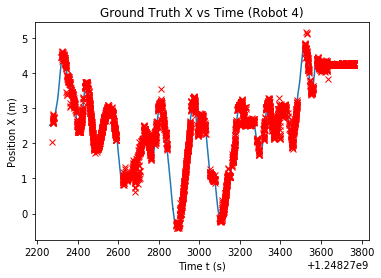

In [64]:
plt.plot(gt5[:, 0], gt5[:, 1]) #plot x vs t
plt.plot([item[0] for item in meas_log[4]], [item[1] for item in meas_log[4]], "rx")
plt.title("Ground Truth X vs Time (Robot 4)")
plt.xlabel("Time t (s)")
plt.ylabel("Position X (m)")
# plt.plot(est_times[3], r4_x, "r")
# plt.plot(est_times[3], r4_y, "k")

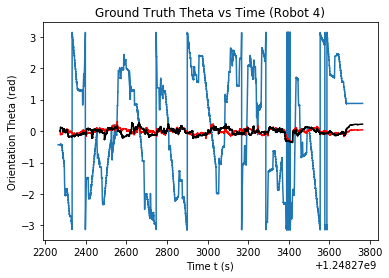

In [65]:
plt.plot(gt4[:, 0], gt4[:, 3]) #plot theta vs t
plt.title("Ground Truth Theta vs Time (Robot 4)")
plt.xlabel("Time t (s)")
plt.ylabel("Orientation Theta (rad)")
plt.plot(est_times[3], r4_x, "r")
plt.plot(est_times[3], r4_y, "k")

/Users/christinalau/anaconda/envs/eng208/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/christinalau/anaconda/envs/eng208/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


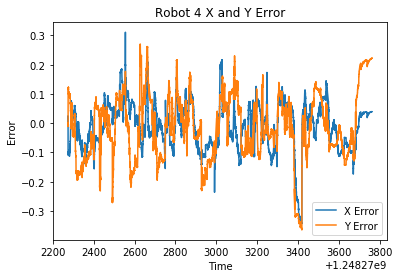

In [66]:
plt.plot(est_times[3], r4_x)
plt.plot(est_times[3], r4_y)

plt.title('Robot 4 X and Y Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(['X Error', 'Y Error'])

In [67]:
numMeas = 0
for i in range(5):
    numMeas += len([item[0] for item in meas_log[i]])
print(numMeas)

16575


## Output Plots

In [68]:
# plt.plot(est_times[0])
est_times[0]

array([1.24827227e+09, 1.24827227e+09, 1.24827227e+09, ...,
       1.24827376e+09, 1.24827376e+09, 1.24827376e+09])

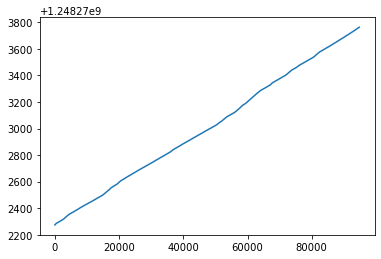

In [69]:
plt.plot(est_times[1])

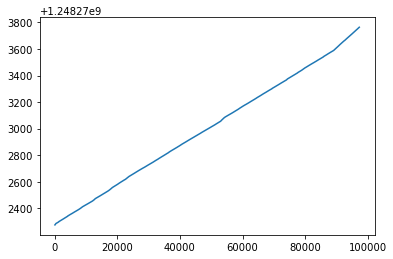

In [70]:
plt.plot(est_times[2])

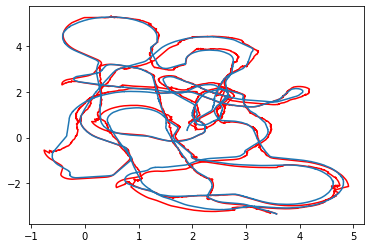

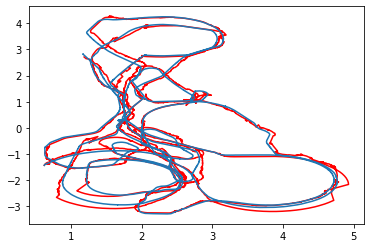

In [108]:
plt.figure(1)
plt.plot(states[0][0], states[0][1], "r")
plt.plot(robot1_gt_x, robot1_gt_y)

plt.figure(2)
plt.plot(states[1][0], states[1][1], "r")
plt.plot(robot2_gt_x, robot2_gt_y)


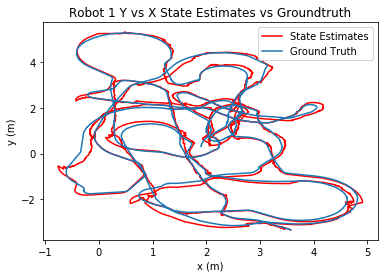

In [71]:
plt.plot(states[0][0], states[0][1], "r")
plt.plot(robot1_gt_x, robot1_gt_y)
plt.title("Robot 1 Y vs X State Estimates vs Groundtruth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(["State Estimates", "Ground Truth"])

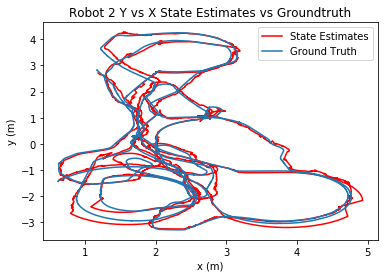

In [72]:
plt.plot(states[1][0], states[1][1], "r")
plt.plot(robot2_gt_x, robot2_gt_y)
plt.title("Robot 2 Y vs X State Estimates vs Groundtruth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(["State Estimates", "Ground Truth"])

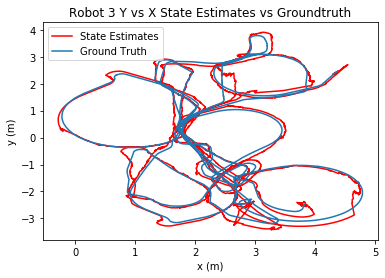

In [73]:
plt.plot(states[2][0], states[2][1], "r")
plt.plot(robot3_gt_x, robot3_gt_y)
plt.title("Robot 3 Y vs X State Estimates vs Groundtruth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(["State Estimates", "Ground Truth"])

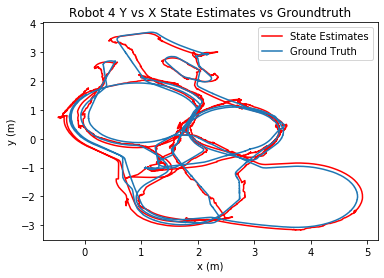

In [74]:
plt.plot(states[3][0], states[3][1], "r")
plt.plot(robot4_gt_x, robot4_gt_y)
plt.title("Robot 4 Y vs X State Estimates vs Groundtruth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(["State Estimates", "Ground Truth"])

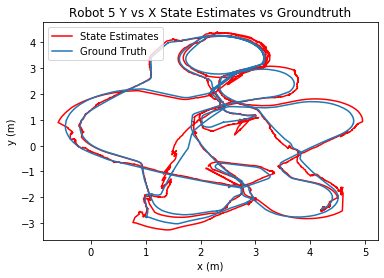

In [92]:
plt.plot(states[4][0], states[4][1], "r")
plt.plot(robot5_gt_x, robot5_gt_y)
plt.title("Robot 5 Y vs X State Estimates vs Groundtruth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend(["State Estimates", "Ground Truth"])

Text(0, 0.5, 'orientation (rad)')

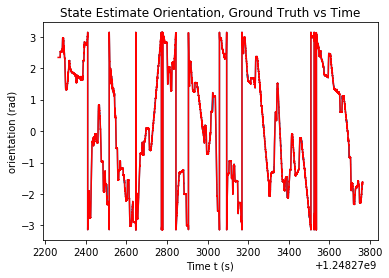

In [76]:
plt.plot(est_times[0], states[0][2])
plt.plot(gt1[:, 0], gt1[:, 3], "r")
plt.title("State Estimate Orientation, Ground Truth vs Time")
plt.xlabel("Time t (s)")
plt.ylabel("orientation (rad)")

## Miscellaneous Code

In [77]:
a = np.array([np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)])

In [78]:
test_dict = {}
for i in range(5):
    penguin = i + 100
    test_dict[i] = penguin

In [79]:
robot1_meas = loadFile("./" + 'MRCLAM_Dataset1' + "/Robot1_Measurement.dat")
test = robot1_meas.to_numpy()

In [80]:
 a = test[test[:,1] == 90]

In [81]:
b = test[:,1] == 90
c = test[:,1] == 18
stuff = b | c 

In [82]:
 a = test[stuff]

In [83]:
for i in range(5):
    print(a[i])

[1.24827228e+09 9.00000000e+01 2.14800000e+00 2.50000000e-02]
[1.24827228e+09 9.00000000e+01 2.03300000e+00 2.40000000e-02]
[1.24827228e+09 9.00000000e+01 1.94600000e+00 4.00000000e-02]
[1.24827228e+09 9.00000000e+01 1.82600000e+00 4.30000000e-02]
[1.24827228e+09 9.00000000e+01 1.82600000e+00 4.30000000e-02]


In [84]:
for i in range(10):
    print(a[i])

[1.24827228e+09 9.00000000e+01 2.14800000e+00 2.50000000e-02]
[1.24827228e+09 9.00000000e+01 2.03300000e+00 2.40000000e-02]
[1.24827228e+09 9.00000000e+01 1.94600000e+00 4.00000000e-02]
[1.24827228e+09 9.00000000e+01 1.82600000e+00 4.30000000e-02]
[1.24827228e+09 9.00000000e+01 1.82600000e+00 4.30000000e-02]
[1.24827228e+09 9.00000000e+01 1.82600000e+00 4.30000000e-02]
[1.24827228e+09 9.00000000e+01 1.78200000e+00 5.80000000e-02]
[1.24827228e+09 9.00000000e+01 1.71000000e+00 3.90000000e-02]
[ 1.24827228e+09  9.00000000e+01  1.67700000e+00 -3.10000000e-02]
[ 1.24827228e+09  9.00000000e+01  1.64500000e+00 -1.40000000e-02]


In [85]:
robot1_meas = loadFile("./" + 'MRCLAM_Dataset1' + "/Robot1_Measurement.dat").to_numpy()

In [86]:
robot1_meas.shape

(5723, 4)

In [87]:
test27 = np.zeros(5, dtype = bool)

In [88]:
a = getMeasurements('MRCLAM_Dataset1', [5, 14, 41, 32, 23])

In [89]:
beep = a[0]
beep

array([[ 1.24827228e+09,  1.40000000e+01,  3.38700000e+00,
         6.00000000e-03,  3.08034233e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.30900000e+00,
        -1.50000000e-02,  2.65404082e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.27200000e+00,
        -2.30000000e-02,  2.83970413e+00],
       ...,
       [ 1.24827374e+09,  4.10000000e+01,  3.89000000e+00,
         4.63000000e-01, -1.74605506e+00],
       [ 1.24827375e+09,  4.10000000e+01,  3.73800000e+00,
         4.77000000e-01, -2.00462220e+00],
       [ 1.24827375e+09,  4.10000000e+01,  3.73800000e+00,
         4.78000000e-01, -1.62470019e+00]])

In [90]:
beep[(beep[:,0] > 1248272278.237) & (beep[:,0] < 1248272282.839)]

array([[ 1.24827228e+09,  1.40000000e+01,  3.16500000e+00,
        -5.10000000e-02,  3.23663265e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.11800000e+00,
        -7.00000000e-02,  3.11307369e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.09800000e+00,
        -7.60000000e-02,  2.21945760e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.06500000e+00,
        -8.00000000e-02,  2.82844434e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.06500000e+00,
        -8.00000000e-02,  2.47963665e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.06500000e+00,
        -8.00000000e-02,  2.49305933e+00],
       [ 1.24827228e+09,  1.40000000e+01,  3.01100000e+00,
        -8.90000000e-02,  2.65734265e+00],
       [ 1.24827228e+09,  1.40000000e+01,  2.91200000e+00,
        -1.21000000e-01,  2.58745058e+00]])

In [91]:
test[0]

array([1.24827228e+09, 9.00000000e+01, 2.14800000e+00, 2.50000000e-02])